In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.decomposition import PCA,KernelPCA
from sklearn.manifold import TSNE
import os
import pickle
import importlib
import detect_bursts
importlib.reload(detect_bursts)
import xlrd
import copy
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

Loading ALdata

In [2]:
def convertIntoFloatList(str):
    #preprocess data extracted
    #remove the "[" and "]" characters
    str = str[1:-1]
    if str == '':
        return None
    return np.array(str.split(','),dtype = float)

def readData(frame):
    #convert dataframe rows into an entire list
    tp = []
    for ind in frame.index:
        inc = convertIntoFloatList(frame[ind])
        if inc is not None:
            tp.append(inc)
    return tp

#load xlsx data, extract column with largest pre_stim
def argMaxPreStim(mothNum):

    dir = os.getcwd()
    #load data from csv file
    loadPath =  os.path.join(dir,f'ALdata/timestamps_{mothNum}.csv')

    df = pd.read_csv(loadPath,header=0)

    argMaxColName = df.columns[np.argmax(df.iloc[0][2:]) + 2]
    print(f"##########current stimuli referenced: {argMaxColName}##########")
    return argMaxColName

#load csv data, extract timestamps
def loadData(mothNum):

    dir = os.getcwd()
    #load data from csv file
    loadPath =  os.path.join(dir,f'ALdata/{mothNum}_pre_stim_cleaned.csv')

    df = pd.read_csv(loadPath, header = 0)
    
    #take samples with stimuli giving largest pre_stim value in first row
    Df = df.loc[df['stimuli'] == argMaxPreStim(mothNum)]

    tempDf = []

    neuronCols = list(Df.columns[3:])
    for neuron in neuronCols:
        curArr = readData(Df[neuron])
        tempDf += curArr

    return tempDf

Derive Nine Parameters

In [3]:
#within-burst number of spikes
def withinBurstNumSpikes(burstIndicator):
    num = len(np.where(burstIndicator == 1)[0])
    percentage = num/burstIndicator.shape[0]
    return num,percentage

#burst duration and inter-burst interval
def durations(timestamps,finalBurstRanges):
    burst = timestamps[finalBurstRanges[0][1]] - timestamps[finalBurstRanges[0][0]]
    #here we assume interBurst doesn't include the start-first-burst interval or the last-burst-end interval
    interBurstSt = finalBurstRanges[0][1]
    interBurst = 0

    maxSpikingFreq = (finalBurstRanges[0][1] - finalBurstRanges[0][0] + 1)/burst

    #tuple representing current burst
    for tup in finalBurstRanges[1:]:
        burstInc = timestamps[tup[1]] - timestamps[tup[0]]
        burst += burstInc
        interBurst += timestamps[tup[0]] - timestamps[interBurstSt]
        interBurstSt = tup[1]

        #count spikes within current burst
        curSpikingFreq = (tup[1]-tup[0]+1)/burstInc
        if maxSpikingFreq < curSpikingFreq:
            maxSpikingFreq = curSpikingFreq

    return burst,interBurst,maxSpikingFreq

#within-burst spiking frequency
def meanSpikingFreq(num,duration):
    return num/duration

#surprise values
def surpriseEval(finalBurstSurprises):
    meanSurprise = np.mean(finalBurstSurprises)
    maxSurprise = np.max(finalBurstSurprises)
    return meanSurprise,maxSurprise

#mean burst frequency
def meanBurstFreq(finalNumBursts,totalTime):
    meanburstFreq = finalNumBursts/totalTime
    return meanburstFreq

#render 9 parameters for each sample (1 trial of 1 neuron)
def renderParams(timestamps,finalBurstRanges,finalBurstSurprises,burstIndicator,finalNumBursts,totalTime):
    withinBurstSpikeNum,withinBurstSpikePercentage = withinBurstNumSpikes(burstIndicator)
    duration,interBurst,maxSpikingFreq = durations(timestamps,finalBurstRanges)
    meanSpikingFreq = withinBurstSpikeNum/duration
    meanSurprise,maxSurprise = surpriseEval(finalBurstSurprises)
    meanburstFreq = meanBurstFreq(finalNumBursts,totalTime)
    return [duration,meanSpikingFreq,maxSpikingFreq,withinBurstSpikeNum,\
            interBurst,withinBurstSpikePercentage,meanburstFreq,meanSurprise,maxSurprise]

#start collecting data for logistic regression
def collectModelData(mothNames):
    #for each moth, for each trial, for each neuron, render 9 parameters
    totalDf = []
    for mothName in mothNames:
        mothDf = loadData(mothName)
        print(f"########current number of rows: {len(mothDf)}########")
        totalDf += mothDf
    
    print("############all data loaded############")
    #print row number of totalDf
    print(f"############totalDf row number{len(totalDf)}############")

    return totalDf

def formulateDataset(totalDf):
    sampleDataset = []
    for dfRow in totalDf:
        lInput = [0] + dfRow
        burstIndicator,finalNumBursts,finalBurstRanges,finalBurstSurprises,totalTime = detect_bursts.detectBursts(lInput,0,math.inf,2)
        sampleDataset.append(renderParams(lInput,finalBurstRanges,finalBurstSurprises,burstIndicator,finalNumBursts,totalTime))
    return sampleDataset

In [4]:
mothNames = ['070906', '070913', '070921', '070922', '070924_1', '070924_2', '071002']
totalDf = collectModelData(mothNames)

##########current stimuli referenced: P9_TenThous##########
########current number of rows: 60########
##########current stimuli referenced: M6##########
########current number of rows: 35########
##########current stimuli referenced: M3##########
########current number of rows: 70########
##########current stimuli referenced: DatExt##########
########current number of rows: 75########
##########current stimuli referenced: P4##########
########current number of rows: 75########
##########current stimuli referenced: P4##########
########current number of rows: 75########
##########current stimuli referenced: P3##########
########current number of rows: 70########
############all data loaded############
############totalDf row number460############


In [ ]:
#not run if sampleDataset.pkl already exists
#formulate dataset
sampleDataset = formulateDataset(totalDf)

#save sampleDataset
with open('sampleDataset.pkl', 'wb') as f:
    pickle.dump(sampleDataset, f)

In [4]:
#extract sampleDataset from pickle file
with open('sampleDataset.pkl', 'rb') as f:
    sampleDataset = pickle.load(f)

#save data into csv file
def saveData(Dataset):
    #load data from csv file
    savePath =  './sampleDataset.csv'

    df = pd.DataFrame(Dataset,columns=['duration','meanSpikingFreq','maxSpikingFreq','withinBurstSpikeNum',\
                                             'interBurst','withinBurstSpikePercentage','meanburstFreq','meanSurprise','maxSurprise'])
    
    #also include subject and stimuli name
    df['Subject'] = ['070906']*60 + ['070913']*35 + ['070921']*70\
    + ['070922']*75+ ['070924_1']*75 + ['070924_2']*75 + ['071002']*70
    df['Stimuli'] = ['P9_TenThous']*60 + ['M6']*35 + ['M3']*70\
    + ['DatExt']*75+ ['P4']*150 + ['P3']*70 
    
    df.to_csv(savePath, index=False)
    return df

df = saveData(sampleDataset)

In [5]:
def reductionClustering(sampleDF,lstColumnNames,reductionFunc,reductionParams,clusteringFunc,clusteringParams,shuffleRandomState,isShuffle = True):
    #setup unsupervised classification training
    #shuffle sample dataset
    if isShuffle:
        sampleDF = shuffle(sampleDF,random_state=shuffleRandomState)

    #normalization
    sample = preprocessing.normalize(sampleDF.loc[:,lstColumnNames])

    #KMeans classification
    clusteringModel = clusteringFunc(**clusteringParams)

    #fit clustering model
    clusteringModel.fit(sample)

    #dimensionality reduction
    reducedSample = reductionFunc(**reductionParams).fit_transform(sample)

    #put last columns back to reducedSample and form new dataframe
    reducedSample = np.hstack((reducedSample,sampleDF.loc[:,['Subject','Stimuli']].to_numpy()))
    reducedSampleDF = pd.DataFrame(reducedSample,columns = ['PC1','PC2','Subject','Stimuli'])
    
    #add label to sample dataframes
    reducedSampleDF['label'] = copy.deepcopy(clusteringModel.labels_)
    sampleDF['label'] = copy.deepcopy(clusteringModel.labels_)
    

    return sampleDF,reducedSampleDF


lstColumnNames = list(df.columns[:-2])
#TSNE
TSNEparams = {'n_components':2,'random_state':42}

#KPCA
KPCAparams = {'n_components':2,'kernel':'linear'}

#KMeans
KMeansParams = {'n_clusters':2,'random_state':42}

#Result
DF,reducedSampleDF = reductionClustering(df,lstColumnNames,KernelPCA,KPCAparams,KMeans,KMeansParams,42,isShuffle = True)

Statistics Result Analysis

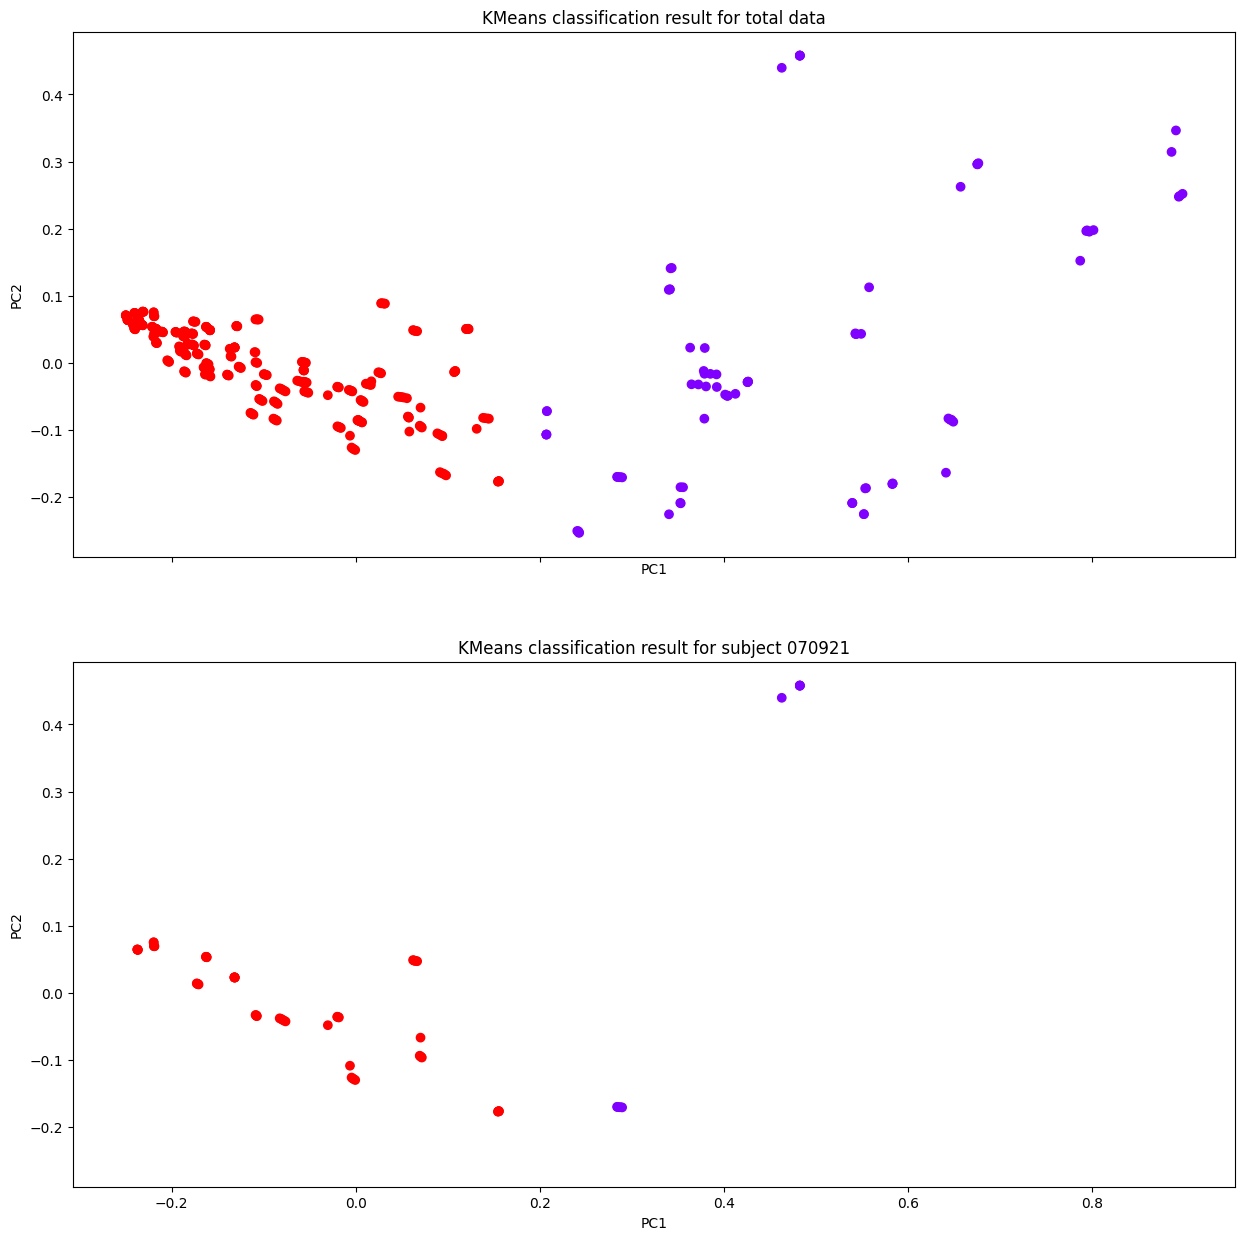

In [6]:
#extract numpy array from dataframe df with designated columns and subject default = 070921
#neglect the last two columns (subject and stimuli)
def extractNumpyArray(DF,lstColumnNames,subject):
    extractedDF = DF.loc[DF['Subject'] == subject]
    extractedDF = extractedDF.loc[:,lstColumnNames]
    return extractedDF


def classificationResultPlot(reducedSampleDF,lstColumnNames = ['PC1','PC2','label'] ,subject = '070921'):
    #extract reducedSampleDF
    extractedReducedSampleDF = extractNumpyArray(reducedSampleDF,lstColumnNames,subject)
    #plotting according to kmeans clustering classification result
    fig,axs = plt.subplots(2,1,sharex = True,sharey = True,figsize=(15,15))

    axs[0].scatter(reducedSampleDF['PC1'],reducedSampleDF['PC2'],c=reducedSampleDF['label'],cmap='rainbow')
    axs[0].set_xlabel('PC1')
    axs[0].set_ylabel('PC2')
    axs[0].set_title('KMeans classification result for total data')

    axs[1].scatter(extractedReducedSampleDF['PC1'],extractedReducedSampleDF['PC2'],c=extractedReducedSampleDF['label'],cmap='rainbow')
    axs[1].set_xlabel('PC1')
    axs[1].set_ylabel('PC2')
    axs[1].set_title('KMeans classification result for subject 070921')

    #plt.legend()
    plt.show()

    #plot according to subject

    #save figures
    fig.savefig('kmeans.png')

classificationResultPlot(reducedSampleDF)

In [7]:
#give number of datapoints in each cluster
def numberDatapointsInClusters(DF):
    #group by label
    groupedDF = DF.groupby('label')
    #count number of datapoints in each cluster
    countDF = groupedDF.count()
    return countDF

print(numberDatapointsInClusters(DF))

       duration  meanSpikingFreq  maxSpikingFreq  withinBurstSpikeNum  \
label                                                                   
0            85               85              85                   85   
1           375              375             375                  375   

       interBurst  withinBurstSpikePercentage  meanburstFreq  meanSurprise  \
label                                                                        
0              85                          85             85            85   
1             375                         375            375           375   

       maxSurprise  Subject  Stimuli  
label                                 
0               85       85       85  
1              375      375      375  


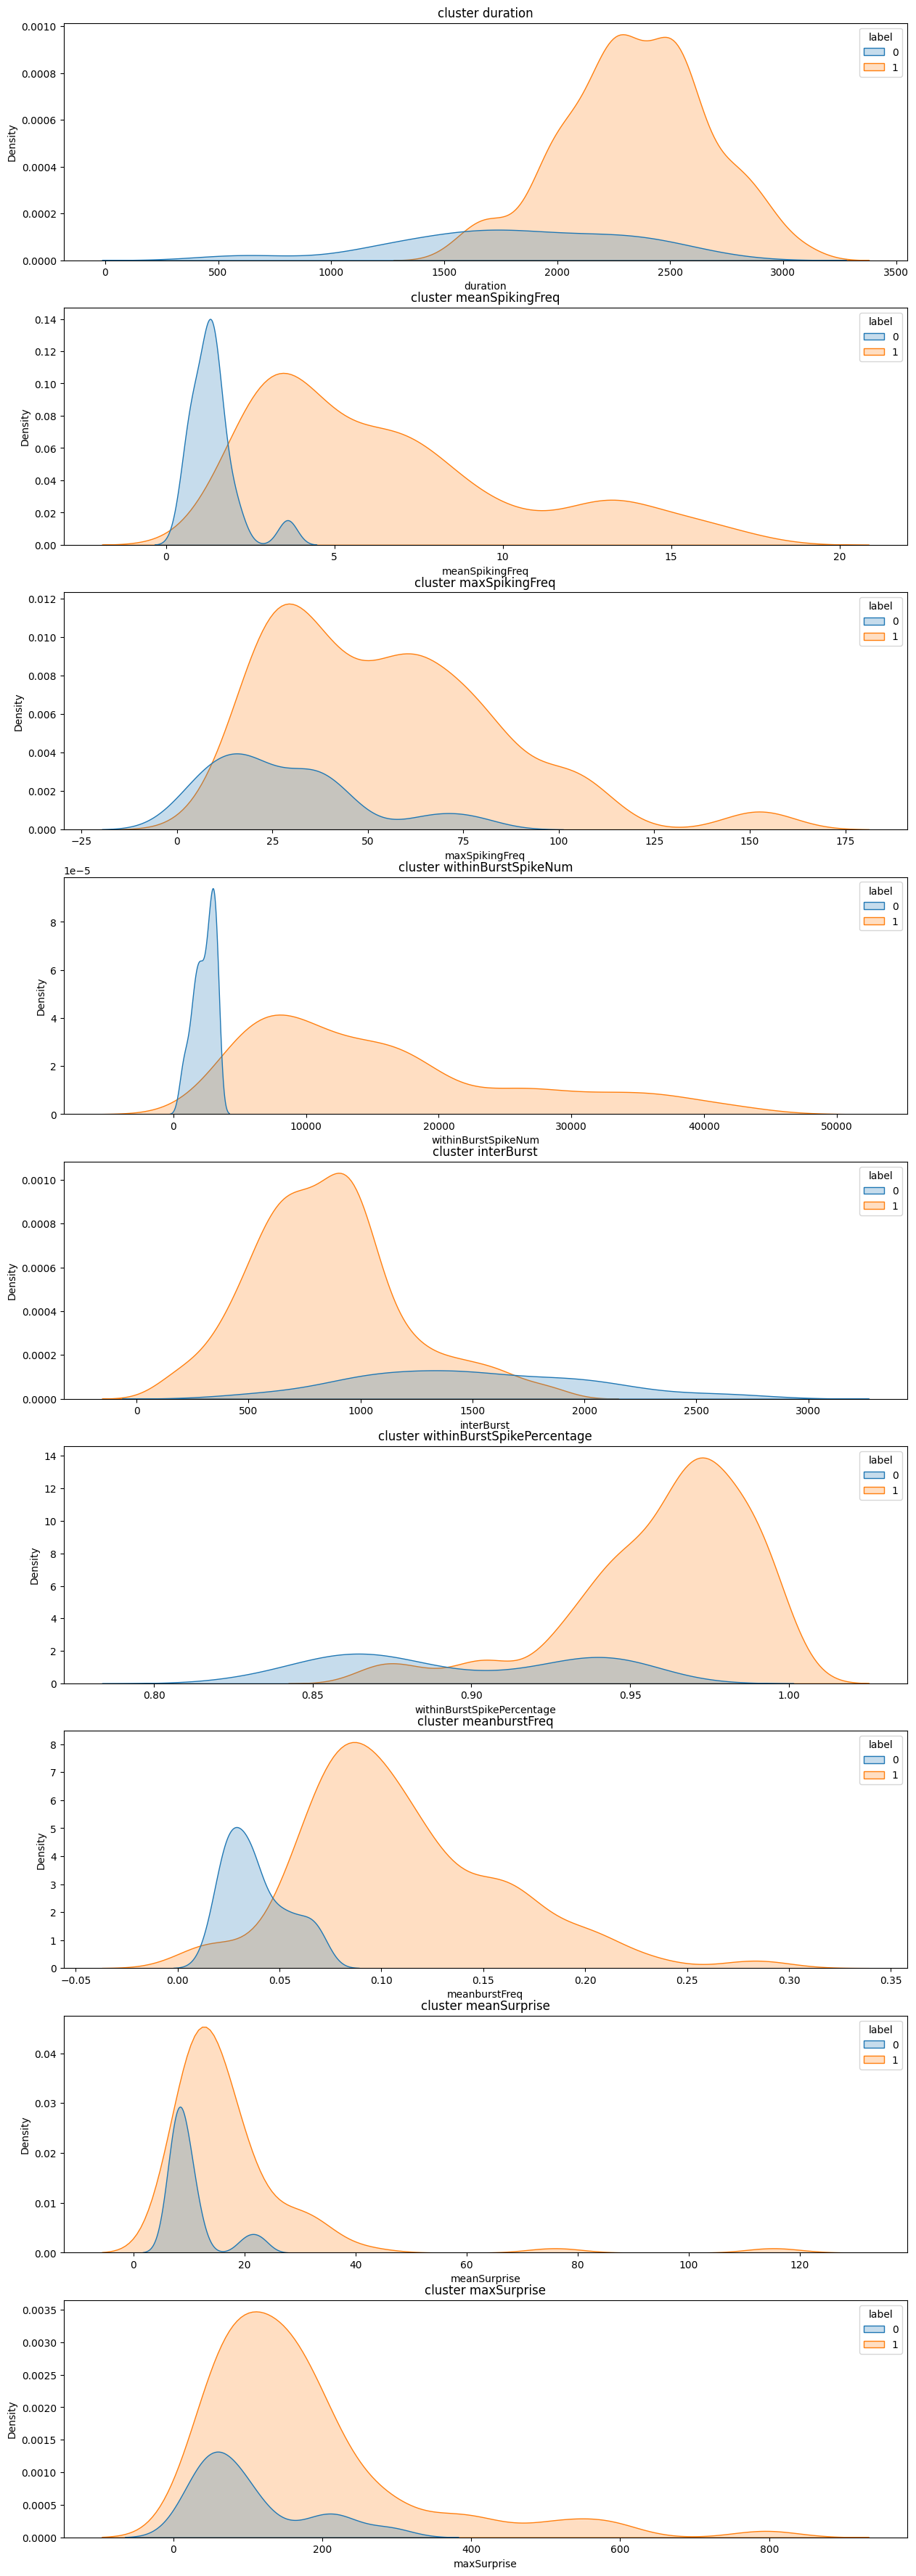

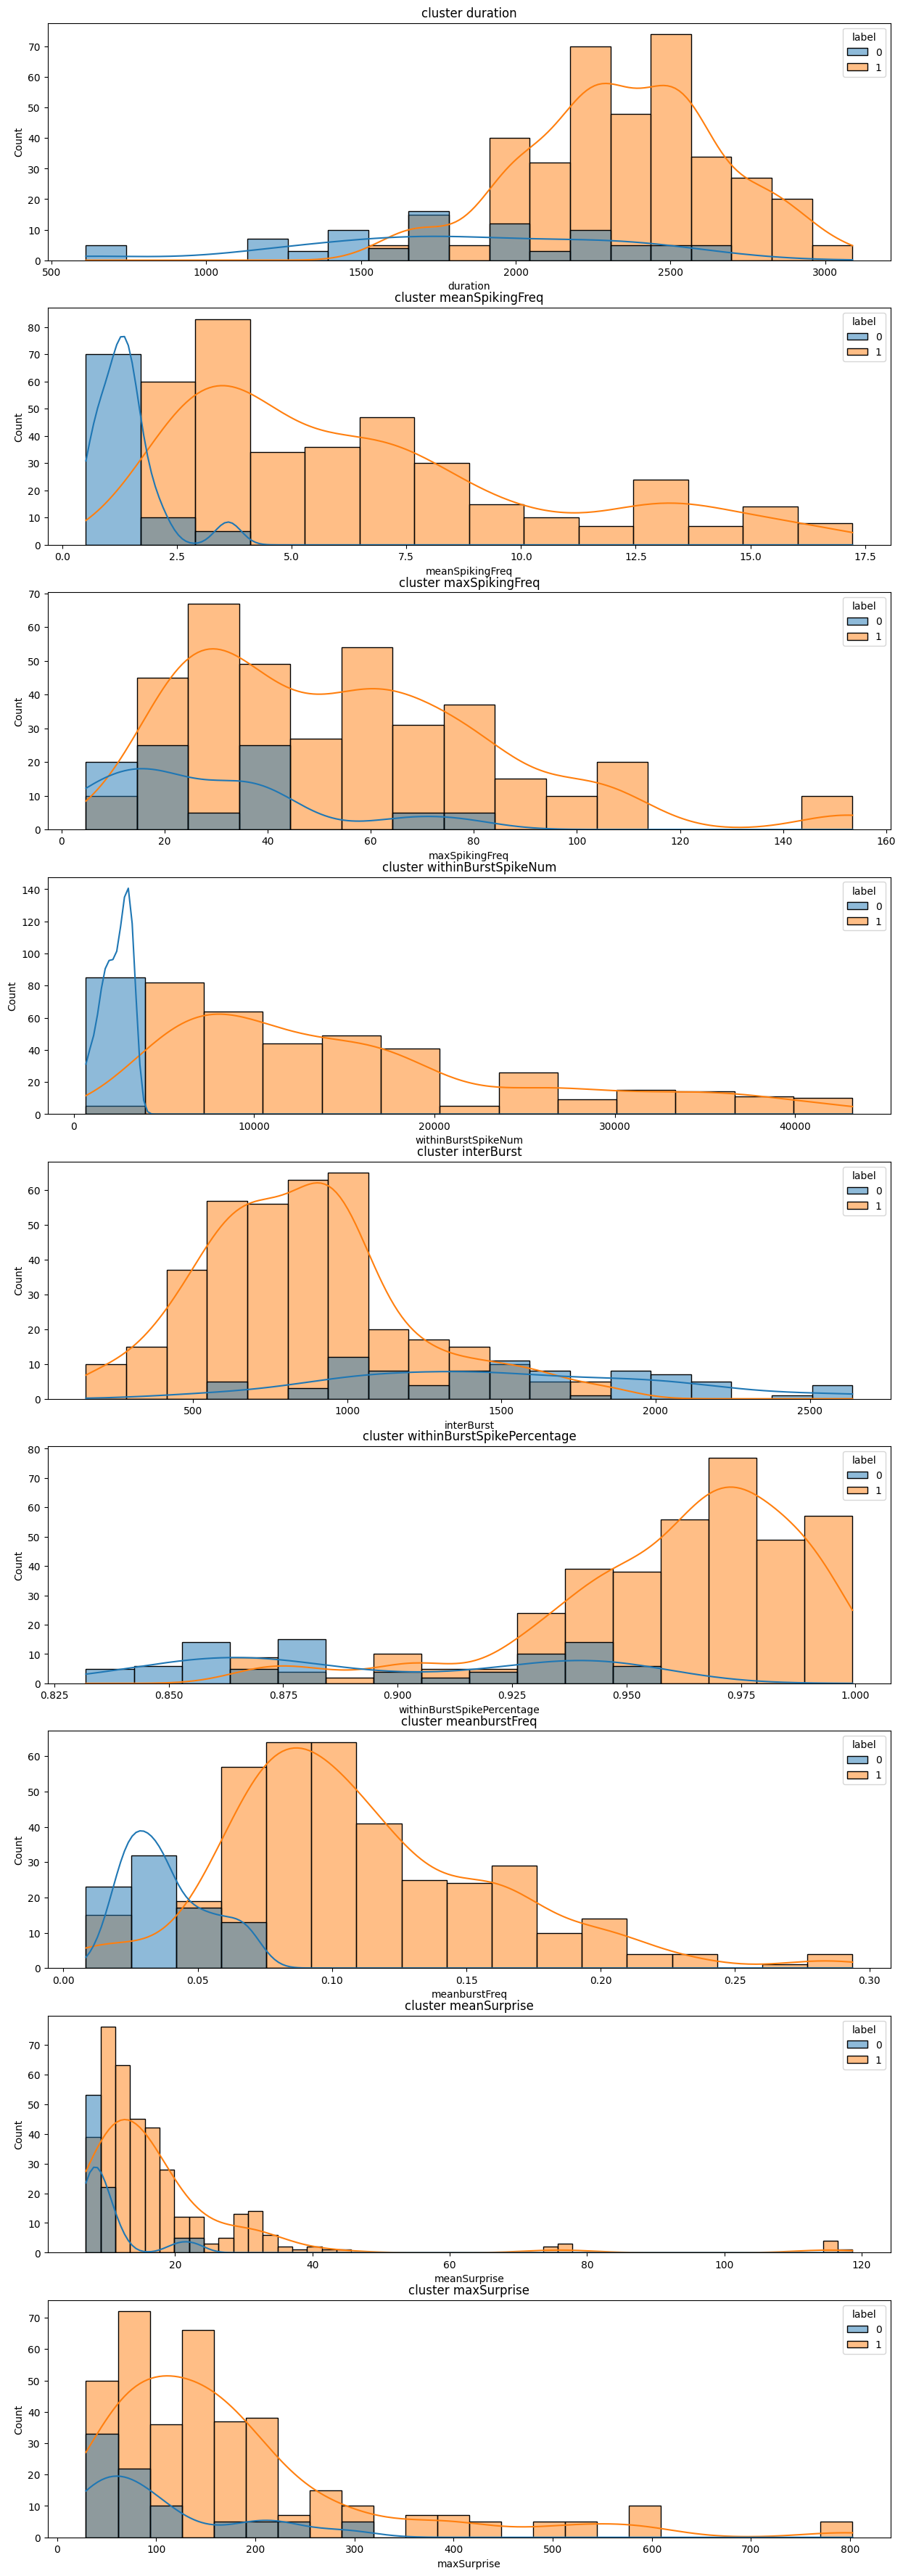

In [19]:
def histoResults(DF,lstColumnNames,plotFunc,plotParams,saveFileName = 'histograms.jpg'):
    #bar plot
    fig,ax = plt.subplots(9,1,figsize=(15,45))

    #sns plot with hue of each of the nine parameters on a row for datapoints in each cluster
    for j in range(9):
        plotFunc(data=DF,x=lstColumnNames[j],ax=ax[j],**plotParams)

        ax[j].set_title(f'cluster {lstColumnNames[j]}')

    plt.show()
    fig.savefig(saveFileName)
    return

histoResults(DF,DF.columns[:9],sns.kdeplot,{'shade':True,'legend':True,'hue':'label'},saveFileName = 'kdeplot.jpg')

histoResults(DF,DF.columns[:9],sns.histplot,{'kde':True,'legend':True,'hue':'label'})
